In [110]:
%matplotlib widget

import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_plate_number,
    get_postion_number,
)

import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.node_id import orient
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.experiment_class_surf import Experiment, Edge, Node
from amftrack.pipeline.paths.directory import (
    run_parallel,
    find_state,
    directory_scratch,
    directory_project,
)

In [111]:
directory = "/projects/0/einf914/data/"

In [125]:
plate = 40
begin = 153
end = begin + 37
dates_datetime = get_dates_datetime(directory, plate)
dates_datetime.sort()
dates_datetime_chosen = dates_datetime[begin : end + 1]
dates = dates_datetime_chosen
exp = Experiment(directory)
exp.load(dates, labeled=False)

In [128]:
edges = set()
for t in range(exp.ts):
    graph = exp.nx_graph[t]
    for edge in graph.edges:
        edge_obj = Edge(Node(min(edge), exp), Node(max(edge), exp), exp)
        edges.add(edge_obj)

In [129]:
edge = choice(list(edges))
print(edge.ts(), len(edge.pixel_list(edge.ts()[0])))

[35] 38


In [122]:
plt.rcParams.update({"font.size": 22})
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(edge.ts(), [edge.width(t) for t in edge.ts()])
ax.set_xlabel("timestep")
ax.set_ylabel(r"width ($\mu m $)")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyError: 'width'

In [130]:
[edge.width(t) for t in edge.ts()]

[3.8752887857676472]

In [5]:
t0 = 33
pixels = []
for edge in edges:
    if edge.is_in(t0):
        pixels.append(((edge.begin.pos(t0) + edge.end.pos(t0)) / 2, edge.width(t0)))

In [56]:
help(plt.cm.get_cmap("plasma"))

Help on ListedColormap in module matplotlib.colors object:

class ListedColormap(Colormap)
 |  ListedColormap(colors, name='from_list', N=None)
 |  
 |  Colormap object generated from a list of colors.
 |  
 |  This may be most useful when indexing directly into a colormap,
 |  but it can also be used to generate special colormaps for ordinary
 |  mapping.
 |  
 |  Method resolution order:
 |      ListedColormap
 |      Colormap
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, colors, name='from_list', N=None)
 |      Make a colormap from a list of colors.
 |      
 |      *colors*
 |          a list of matplotlib color specifications,
 |          or an equivalent Nx3 or Nx4 floating point array
 |          (*N* rgb or rgba values)
 |      *name*
 |          a string to identify the colormap
 |      *N*
 |          the number of entries in the map.  The default is *None*,
 |          in which case there is one colormap entry for each
 |          element in

In [134]:
t0 = 20
plt.close("all")
# fig = plt.figure()
# ax = fig.add_subplot(111)
exp.plot_raw(t0)
for edge in edges:
    if edge.is_in(t0):
        try:
            width = edge.width(t0)
        except:
            print(edge)
        begin = edge.begin.pos(t0)
        end = edge.end.pos(t0)
        plt.plot(
            (begin[1] // 5, end[1] // 5),
            (begin[0] // 5, end[0] // 5),
            color=plt.cm.get_cmap("plasma")(width / 12),
        )
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.get_cmap("plasma"), norm=plt.Normalize(vmin=0, vmax=12)
)
sm._A = []
plt.colorbar(sm)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
edge0width = [edge for edge in edges if edge.is_in(t0) and edge.width(t0) == 0]

In [34]:
x, y, c = (
    [pixel[0][0] for pixel in pixels],
    [pixel[0][1] for pixel in pixels],
    [pixel[1] for pixel in pixels],
)

In [35]:
X, Y = np.meshgrid(x, y)

ValueError: not enough values to unpack (expected 2, got 1)

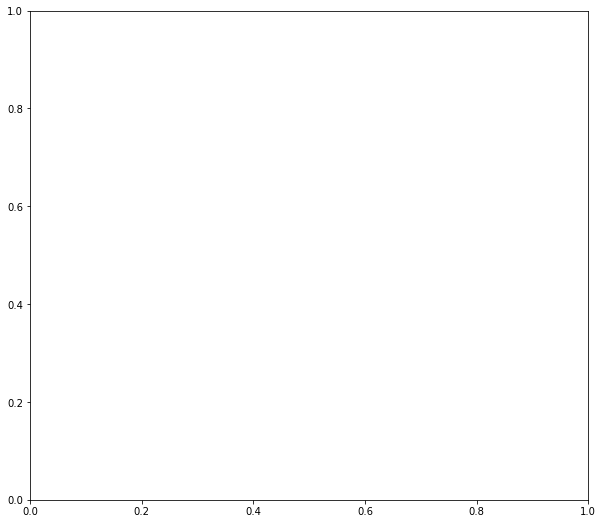

In [37]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.pcolormesh(X, Y, c)

In [38]:
np.random.rand(6, 10)

array([[0.65184612, 0.66056643, 0.12499956, 0.7364519 , 0.1793078 ,
        0.42830398, 0.86415191, 0.46723791, 0.28685484, 0.60543425],
       [0.49024466, 0.03816605, 0.63126177, 0.15640546, 0.02297815,
        0.33344225, 0.58576963, 0.0881237 , 0.1128793 , 0.69476874],
       [0.42492862, 0.43227348, 0.42959667, 0.49371282, 0.17220331,
        0.04714904, 0.17751601, 0.3878863 , 0.24217817, 0.54123831],
       [0.33657338, 0.69719528, 0.38260422, 0.00809375, 0.49907962,
        0.62683143, 0.42223888, 0.61668441, 0.16818435, 0.96519325],
       [0.14741769, 0.33200052, 0.45050359, 0.47443733, 0.86062992,
        0.11826813, 0.78142622, 0.61928262, 0.69741385, 0.94069517],
       [0.14954074, 0.29846353, 0.80996295, 0.5451993 , 0.14765597,
        0.81791178, 0.35439332, 0.22418863, 0.1677418 , 0.09178806]])

In [90]:
edge = choice(edge0width)

In [101]:
widths = get_width_edge(edge, 50, t0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [99]:
edge.end.show_source_image(5, 5)
edge.begin.show_source_image(5, 5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [100]:
from skimage.measure import profile_line
from amftrack.notebooks.analysis.util import *
from scipy.optimize import curve_fit
import numpy as np

a = 2.65649932
from scipy import special


def func2(x, lapse, lapse2, c, d, e):
    return (
        -c * (special.erf(e * (x - lapse)) - special.erf(e * (x - lapse - lapse2))) + d
    )


def func3(x, lapse, lapse2, c, d, e, lapse4):
    return (
        -c * (special.erf(e * (x - lapse)) - special.erf(e * (x - (lapse + lapse2))))
        + d
        + c
        * (
            special.erf(e * (x - (lapse + lapse2)))
            - special.erf(e * (x - (lapse + lapse2 + lapse4)))
        )
    )


def func4(x, lapse, lapse2, c, d, e, lapse4):
    return (
        -c * (special.erf(e * (x - lapse)) - special.erf(e * (x - (lapse + lapse2))))
        + d
        + c * (special.erf(e * (x - (lapse - lapse4))) - special.erf(e * (x - (lapse))))
    )


def func5(x, sigma, mean, fact, offset):
    return -fact * np.exp(-((x - mean) ** 2) / sigma**2) + offset


def func5(x, sigma, mean, fact, offset):
    return -fact * np.exp(-((x - mean) ** 2) / sigma**2) + offset


def get_source_image(experiment, pos, t, local, force_selection=None):
    x, y = pos[0], pos[1]
    ims, posimg = experiment.find_image_pos(x, y, t, local)
    if force_selection is None:
        dist_border = [
            min([posimg[1][i], 3000 - posimg[1][i], posimg[0][i], 4096 - posimg[0][i]])
            for i in range(posimg[0].shape[0])
        ]
        j = np.argmax(dist_border)
    else:
        dist_last = [
            np.linalg.norm(
                np.array((posimg[1][i], posimg[0][i])) - np.array(force_selection)
            )
            for i in range(posimg[0].shape[0])
        ]
        j = np.argmin(dist_last)
    return (ims[j], (posimg[1][j], posimg[0][j]))


def get_width_pixel(
    edge,
    index,
    im,
    pivot,
    before,
    after,
    t,
    size=20,
    width_factor=60,
    averaging_size=100,
    threshold_averaging=10,
):
    imtab = im
    #     print(imtab.shape)
    #     print(int(max(0,pivot[0]-averaging_size)),int(pivot[0]+averaging_size))
    threshold = np.mean(
        imtab[
            int(max(0, pivot[0] - averaging_size)) : int(pivot[0] + averaging_size),
            int(max(0, pivot[1] - averaging_size)) : int(pivot[1] + averaging_size),
        ]
        - threshold_averaging
    )
    orientation = np.array(before) - np.array(after)
    perpendicular = (
        [1, -orientation[0] / orientation[1]] if orientation[1] != 0 else [0, 1]
    )
    perpendicular_norm = np.array(perpendicular) / np.sqrt(
        perpendicular[0] ** 2 + perpendicular[1] ** 2
    )
    point1 = np.around(np.array(pivot) + width_factor * perpendicular_norm)
    point2 = np.around(np.array(pivot) - width_factor * perpendicular_norm)
    point1 = point1.astype(int)
    point2 = point2.astype(int)
    p = profile_line(imtab, point1, point2, mode="constant")
    xdata = np.array(range(len(p)))
    ydata = np.array(p)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xdata, ydata)
    try:
        p00 = [10, 60, 60, 160]
        popt0, pcov = curve_fit(
            func5, xdata, ydata, bounds=([0, 0, 0, 0], 4 * [np.inf]), p0=p00
        )
        ax.plot(xdata, func5(xdata, *popt0), "g-")
        p0a = [60, 10, 100, 180, 0.1]
        popt1, pcov = curve_fit(
            func2,
            xdata,
            ydata,
            bounds=([0, 0, 0, 0, 0], [120, 120, 200] + 2 * [np.inf]),
            p0=p0a,
        )
        p0b = list(popt1) + [10]
        popt2, pcov = curve_fit(
            func3,
            xdata,
            ydata,
            bounds=([0, 0, 0, 0, 0, 0], [120, 120, 200] + 2 * [np.inf] + [120]),
            p0=p0b,
        )
        residuals = ydata - func3(xdata, *popt2)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
        r_squared1 = 1 - (ss_res / ss_tot)
        popt3, pcov = curve_fit(
            func4,
            xdata,
            ydata,
            bounds=([0, 0, 0, 0, 0, 0], [120, 120, 200] + 2 * [np.inf] + [120]),
            p0=p0b,
        )
        residuals = ydata - func4(xdata, *popt3)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
        r_squared2 = 1 - (ss_res / ss_tot)
        #     ax.plot(xdata, func2(xdata, *popt1), 'r-')
        if r_squared1 > r_squared2:
            ax.plot(xdata, func3(xdata, *popt2), "b-")
            popt = popt2
        else:
            ax.plot(xdata, func4(xdata, *popt3), "b-")
            popt = popt3
        background = popt[3]
    except RuntimeError:
        print("failed")
        background = np.mean(p)
    #     print(popt[3],popt0[3])
    #     width_pix = popt0[0]*popt0[2]
    width_pix = -np.sum(np.log10(np.array(p) / background))
    #     print(width_pix)
    #     p0=[165,100,165,45,10,10,10]
    #     popt, pcov = curve_fit(func, xdata, ydata,bounds = ([-np.inf,-np.inf,-np.inf,-np.inf,0,0,0],np.inf),p0=p0)
    #     width_pix = popt[-2]
    #     ax.plot(xdata, func(xdata, *popt), 'r-')
    #     derivative = [p[i+1]-p[i] for i in range(len(p)-1)]
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111)
    #     ax.plot([np.mean(derivative[5*i:5*i+5]) for i in range(len(derivative)//5)])
    #     problem=False
    #     arg = len(p)//2
    #     if p[arg]>threshold:
    #         arg = np.argmin(p)
    # #     we_plot=randrange(1000)
    #     while  p[arg]<=threshold:
    #         if arg<=0:
    # #             we_plot=50
    #             problem=True
    #             break
    #         arg-=1
    #     begin = arg
    #     arg = len(p)//2
    #     if p[arg]>threshold:
    #         arg = np.argmin(p)
    #     while  p[arg]<=threshold:
    #         if arg>=len(p)-1:
    # #             we_plot=50
    #             problem=True
    #             break
    #         arg+=1
    #     end = arg
    # #     print(end-begin,threshold)
    #     print(np.linalg.norm(point1-point2),len(p),width_pix)
    return a * np.sqrt(max(0, np.linalg.norm(point1 - point2) * (width_pix) / len(p)))


def get_width_edge(edge, resolution, t, local=False, threshold_averaging=10):
    pixel_conversion_factor = 1.725
    pixel_list = edge.pixel_list(t)
    pixels = []
    indexes = []
    source_images = []
    poss = []
    widths = {}
    if len(pixel_list) > 3 * resolution:
        for i in range(0, len(pixel_list) // resolution):
            index = i * resolution
            indexes.append(index)
            pixel = pixel_list[index]
            pixels.append(pixel)
            source_img, pos = get_source_image(edge.experiment, pixel, t, local)
            source_images.append(source_img)
            poss.append(pos)
    else:
        indexes = [0, len(pixel_list) // 2, len(pixel_list) - 1]
        for index in indexes:
            pixel = pixel_list[index]
            pixels.append(pixel)
            source_img, pos = get_source_image(edge.experiment, pixel, t, local)
            source_images.append(source_img)
            poss.append(pos)
    #     print(indexes)
    for i, index in enumerate(indexes[1:-1]):
        source_img = source_images[i + 1]
        pivot = poss[i + 1]
        _, before = get_source_image(edge.experiment, pixels[i], t, local, pivot)
        _, after = get_source_image(edge.experiment, pixels[i + 2], t, local, pivot)
        plot_t_tp1(
            [0, 1, 2], [], {0: pivot, 1: before, 2: after}, None, source_img, source_img
        )
        width = get_width_pixel(
            edge,
            index,
            source_img,
            pivot,
            before,
            after,
            t,
            threshold_averaging=threshold_averaging,
        )
        #         print(width*pixel_conversion_factor)
        widths[pixel_list[index]] = width * pixel_conversion_factor
    #         if i>=1:
    #             break
    edge.experiment.nx_graph[t].get_edge_data(edge.begin.label, edge.end.label)[
        "width"
    ] = widths
    return widths


def get_width_info(experiment, t, resolution=50):
    edge_width = {}
    graph = experiment.nx_graph[t]
    #     print(len(list(graph.edges)))
    for edge in graph.edges:
        #         print(edge)
        edge_exp = Edge(
            Node(edge[0], experiment), Node(edge[1], experiment), experiment
        )
        mean = np.mean(list(get_width_edge(edge_exp, resolution, t).values()))
        #         print(np.mean(list(get_width_edge(edge_exp,resolution,t).values())))
        edge_width[edge] = mean
    return edge_width

In [124]:
from amftrack.util.sys import get_dirname
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.extract_graph import (
    generate_skeleton,
    from_nx_to_tab,
    prune_graph,
)
from amftrack.pipeline.functions.node_id import reconnect_degree_2
import ast
from amftrack.plotutil import plot_t_tp1
from amftrack.pipeline.functions.node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from collections import Counter


class Experiment:
    def __init__(self, plate, directory):
        self.plate = plate
        self.directory = directory

    def load(self, dates, labeled=True):
        self.dates = dates
        nx_graph_poss = []
        for date in dates:
            directory_name = get_dirname(date, self.plate)
            path_snap = self.directory + directory_name
            if labeled:
                suffix = "/Analysis/nx_graph_pruned_labeled.p"
            else:
                suffix = "/Analysis/nx_graph_pruned_width.p"
            path_save = path_snap + suffix
            (g, pos) = pickle.load(open(path_save, "rb"))
            nx_graph_poss.append((g, pos))

        nx_graphs = [nx_graph_pos[0] for nx_graph_pos in nx_graph_poss]
        poss = [nx_graph_pos[1] for nx_graph_pos in nx_graph_poss]
        #         nx_graph_clean=[]
        #         for graph in nx_graphs:
        #             S = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
        #             len_connected=[len(nx_graph.nodes) for nx_graph in S]
        #             nx_graph_clean.append(S[np.argmax(len_connected)])
        self.positions = poss
        self.nx_graph = nx_graphs
        self.hyphaes = None
        labels = {node for g in self.nx_graph for node in g}
        self.nodes = []
        for label in labels:
            self.nodes.append(Node(label, self))
        xpos = [pos[0] for poss in self.positions for pos in poss.values()]
        ypos = [pos[1] for poss in self.positions for pos in poss.values()]
        self.boundaries_x = np.min(xpos), np.max(xpos)
        self.boundaries_y = np.min(ypos), np.max(ypos)
        self.ts = len(self.dates)

    def load_compressed_skel(self):
        skeletons = []
        for nx_graph in self.nx_graph:
            skeletons.append(generate_skeleton(nx_graph, dim=(30000, 60000)))
        self.skeletons = skeletons
        compressed_images = []
        for t in range(len(self.dates)):
            compressed_images.append(self.compress_skeleton(t, 5))
        self.compressed = compressed_images

    def copy(self, experiment):
        self.positions = experiment.positions
        self.nx_graph = experiment.nx_graph
        self.skeletons = experiment.skeletons
        self.dates = experiment.dates
        self.plate = experiment.plate
        self.nodes = None
        self.hyphaes = None
        self.boundaries_x = experiment.boundaries_x
        self.boundaries_y = experiment.boundaries_y
        self.compressed = experiment.compressed
        self.ts = experiment.ts

    def save(self, path=f"Data/"):
        tabs_labeled = []
        for i, date in enumerate(self.dates):
            tabs_labeled.append(from_nx_to_tab(self.nx_graph[i], self.positions[i]))
        for i, date in enumerate(self.dates):
            #             tabs_labeled[i].to_csv(path + f"graph_{date}_{self.plate}_full_labeled.csv")
            sio.savemat(
                path + f"graph_{date}_{self.plate}_full_labeled.mat",
                {name: col.values for name, col in tabs_labeled[i].items()},
            )

    def pickle_save(self, path):
        pickle.dump(self, open(path + f"experiment_{self.plate}.pick", "wb"))

    def pickle_load(self, path):
        self = pickle.load(open(path + f"experiment_{self.plate}.pick", "rb"))

    def get_node(self, label):
        return Node(label, self)

    def get_edge(self, begin, end):
        return Edge(begin, end, self)

    def compress_skeleton(self, t, factor):
        shape = self.skeletons[t].shape
        final_picture = np.zeros(shape=(shape[0] // factor, shape[1] // factor))
        for pixel in self.skeletons[t].keys():
            x = min(round(pixel[0] / factor), shape[0] // factor - 1)
            y = min(round(pixel[1] / factor), shape[1] // factor - 1)
            final_picture[x, y] += 1
        return final_picture >= 1

    def get_growing_tips(self, t, threshold=80):
        growths = {
            tip: sum([len(branch) for branch in self.growth_patterns[t][tip]])
            for tip in self.growth_patterns[t].keys()
        }
        growing_tips = [node for node in growths.keys() if growths[node] >= threshold]
        return growing_tips

    def pinpoint_anastomosis(self, t):
        nx_graph_tm1 = self.nx_graph[t]
        nx_grapht = self.nx_graph[t + 1]
        from_tip = self.connections[t]
        pos_tm1 = self.positions[t]
        anastomosis = []
        origins = []
        tips = [node for node in nx_graph_tm1.nodes if nx_graph_tm1.degree(node) == 1]
        number_anastomosis = 0

        def dist_branch(node, nx_graph, pos):
            mini = np.inf
            for edge in nx_graph.edges:
                pixel_list = nx_graph.get_edge_data(*edge)["pixel_list"]
                if (
                    np.linalg.norm(np.array(pixel_list[0]) - np.array(pos[node]))
                    <= 5000
                ):
                    distance = np.min(
                        np.linalg.norm(
                            np.array(pixel_list) - np.array(pos[node]), axis=1
                        )
                    )
                    if distance < mini:
                        mini = distance
            return mini

        def count_neighbors_is_from_root(equ_list, nx_graph, root):
            count = 0
            for neighbor in nx_graph.neighbors(root):
                if neighbor in equ_list:
                    count += 1
            return count

        for tip in tips:
            #         print(tip)
            consequence = from_tip[tip]
            for node in consequence:
                if (
                    node in nx_grapht.nodes
                    and nx_grapht.degree(node) >= 3
                    and count_neighbors_is_from_root(consequence, nx_grapht, node) < 2
                ):
                    #                 if node==2753:
                    #                     print(count_neighbors_is_from_root(consequence,nx_grapht,node))
                    #                     print(list(nx_grapht.neighbors(node)))
                    anastomosis.append(node)
                    origins.append(tip)
                    number_anastomosis += 1
            if (
                tip not in nx_grapht.nodes
                and dist_branch(tip, nx_grapht, pos_tm1) <= 30
                and nx_graph_tm1.get_edge_data(*list(nx_graph_tm1.edges(tip))[0])[
                    "weight"
                ]
                >= 20
            ):
                origins.append(tip)
                number_anastomosis += 1 / 2
        return (anastomosis, origins, number_anastomosis)

    def find_image_pos(self, xs, ys, t, local=False):
        date = self.dates[t]
        directory_name = get_dirname(date, self.plate)
        path_snap = self.directory + directory_name
        path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
        skel = read_mat(path_snap + "/Analysis/skeleton_pruned_realigned.mat")
        Rot = skel["R"]
        trans = skel["t"]
        rottrans = np.dot(np.linalg.inv(Rot), np.array([xs, ys] - trans))
        ys, xs = round(rottrans[0]), round(rottrans[1])
        tileconfig = pd.read_table(
            path_tile,
            sep=";",
            skiprows=4,
            header=None,
            converters={2: ast.literal_eval},
            skipinitialspace=True,
        )
        xs_yss = list(tileconfig[2])
        xes = [xs_ys[0] for xs_ys in xs_yss]
        yes = [xs_ys[1] for xs_ys in xs_yss]
        cmin = np.min(xes)
        cmax = np.max(xes)
        rmin = np.min(yes)
        rmax = np.max(yes)
        ximg = xs
        yimg = ys

        def find(xsub, ysub, x, y):
            indexes = []
            for i in range(len(xsub)):
                if (
                    x >= xsub[i] - cmin
                    and x < xsub[i] - cmin + 4096
                    and y >= ysub[i] - rmin
                    and y < ysub[i] - rmin + 3000
                ):
                    indexes.append(i)
            return indexes

        indsImg = find(xes, yes, ximg, yimg)
        possImg = [
            ximg - np.array(xes)[indsImg] + cmin + 1,
            yimg - np.array(yes)[indsImg] + rmin + 1,
        ]
        paths = []
        for index in indsImg:
            name = tileconfig[0][index]
            imname = "/Img/" + name.split("/")[-1]
            directory_name = get_dirname(date, self.plate)
            path = self.directory + directory_name + imname
            pipeline.paths.append(path)
        ims = [imageio.imread(path) for path in paths]
        return (ims, possImg)

    def plot_raw(self, t):
        date = self.dates[t]
        directory_name = get_dirname(date, self.plate)
        path_snap = self.directory + directory_name
        im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(im)

    def plot(self, ts, node_lists=[], shift=(0, 0), compress=5, save="", time=None):
        global check
        right = 0.90
        top = 0.90
        if len(save) >= 1:
            fig = plt.figure(figsize=(14, 12))
            size = 10
        else:
            fig = plt.figure()
            size = 5
        ax = fig.add_subplot(111)
        scale = 1 / len(ts)
        power = len(ts)
        if compress != 5:
            compressed_images = []
            for i, t in enumerate(ts):
                compressed_images.append(self.compress_skeleton(t, compress))
        else:
            compressed_images = []
            for i, t in enumerate(ts):
                compressed_images.append(self.compressed[t])
        visibility = [True for t in ts]
        final_image = scale * compressed_images[0] * visibility[0]
        for i, compressed_image in enumerate(compressed_images[1:]):
            final_image = np.power(
                final_image**power
                + ((i + 2) * scale * compressed_image * visibility[i + 1]) ** power,
                1 / power,
            )
        l1 = ax.imshow(final_image, cmap="plasma", interpolation="none", vmin=0, vmax=1)
        rax = plt.axes([0.05, 0.4, 0.1, 0.15])
        labels = [f"{4*t}h" for t in ts]
        check = CheckButtons(rax, labels, visibility)

        def func(label):
            index = labels.index(label)
            visibility[index] = not visibility[index]
            final_image = visibility[0] * scale * compressed_images[0]
            for i, compressed_image in enumerate(compressed_images[1:]):
                final_image = np.power(
                    final_image**power
                    + visibility[i + 1] * ((i + 2) * scale * compressed_image) ** power,
                    1 / power,
                )
            l1.set_data(final_image)
            plt.draw()

        check.on_clicked(func)
        if len(node_lists) > 0:
            for i, node_list in enumerate(node_lists):
                grey = (i + 1) / len(labels)
                bbox = dict(boxstyle="circle", fc=colors.rgb2hex((grey, grey, grey)))
                #             ax.text(right, top, time,
                #                 horizontalalignment='right',
                #                 verticalalignment='bottom',
                #                 transform=ax.transAxes,color='white')
                for node in node_list:
                    #                     print(self.positions[ts[i]])
                    if node in self.positions[ts[i]].keys():
                        t = ax.text(
                            (self.positions[ts[i]][node][1] - shift[1]) // compress,
                            (self.positions[ts[i]][node][0] - shift[0]) // compress,
                            str(node),
                            ha="center",
                            va="center",
                            size=size,
                            bbox=bbox,
                        )
        if len(save) >= 1:
            plt.savefig(save)
            plt.close(fig)
        else:
            plt.show()


class Node:
    def __init__(self, label, experiment):
        self.experiment = experiment
        self.label = label

    def __eq__(self, other):
        return self.label == other.label

    def __repr__(self):
        return f"Node({self.label})"

    def __str__(self):
        return str(self.label)

    def __hash__(self):
        return self.label

    def neighbours(self, t):
        return [
            self.experiment.get_node(node)
            for node in self.experiment.nx_graph[t].neighbors(self.label)
        ]

    def is_in(self, t):
        return self.label in self.experiment.nx_graph[t].nodes

    def degree(self, t):
        return self.experiment.nx_graph[t].degree(self.label)

    def edges(self, t):
        return [
            self.experiment.get_edge(self, neighbour)
            for neighbour in self.neighbours(t)
        ]

    def pos(self, t):
        return self.experiment.positions[t][self.label]

    def ts(self):
        return [t for t in range(len(self.experiment.nx_graph)) if self.is_in(t)]

    def show_source_image(self, t, tp1):
        pos = self.pos(t)
        x, y = pos[0], pos[1]
        ims, posimg = self.experiment.find_image_pos(x, y, t)
        i = np.argmax([np.mean(im) for im in ims])
        if t != tp1:
            posp1 = self.pos(tp1)
            xp1, yp1 = posp1[0], posp1[1]
            imsp1, posimgp1 = self.experiment.find_image_pos(xp1, yp1, tp1)
            ip1 = np.argmax([np.mean(im) for im in imsp1])
            plot_t_tp1(
                [self.label],
                [self.label],
                {self.label: (posimg[1][i], posimg[0][i])},
                {self.label: (posimgp1[1][ip1], posimgp1[0][ip1])},
                ims[i],
                imsp1[ip1],
            )
        else:
            plot_t_tp1(
                [self.label],
                [],
                {self.label: (posimg[1][i], posimg[0][i])},
                None,
                ims[i],
                ims[i],
                gray=True,
            )


class Edge:
    def __init__(self, begin, end, experiment):
        self.begin = begin
        self.end = end
        self.experiment = experiment

    def __eq__(self, other):
        return self.begin == other.begin and self.end == other.end

    def __repr__(self):
        return f"Edge({self.begin},{self.end})"

    def __str__(self):
        return str((self.begin, self.end))

    def __hash__(self):
        return (self.begin, self.end).__hash__()

    def is_in(self, t):
        return (self.begin.label, self.end.label) in self.experiment.nx_graph[t].edges

    def ts(self):
        return [t for t in range(self.experiment.ts) if self.is_in(t)]

    def pixel_list(self, t):
        return orient(
            self.experiment.nx_graph[t].get_edge_data(self.begin.label, self.end.label)[
                "pixel_list"
            ],
            self.begin.pos(t),
        )

    def width(self, t):
        return self.experiment.nx_graph[t].get_edge_data(
            self.begin.label, self.end.label
        )["width"]

    def orientation_whole(self, t):
        pixel_list = np.array(self.pixel_list(t))
        vector = pixel_list[-1] - pixel_list[0]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle

    def orientation_begin(self, t, length=20):
        pixel_list = np.array(self.pixel_list(t))
        vector = pixel_list[min(length, len(pixel_list) - 1)] - pixel_list[0]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle

    def orientation_end(self, t, length=20):
        pixel_list = np.array(self.pixel_list(t))
        vector = pixel_list[-1] - pixel_list[max(0, len(pixel_list) - 1 - length)]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle


class Hyphae:
    def __init__(self, tip):
        self.experiment = tip.experiment
        self.ts = tip.ts()
        self.end = tip
        self.root = None
        self.mother = None

    def __eq__(self, other):
        return self.end.label == other.end.label

    def __repr__(self):
        return f"Hyphae({self.end},{self.root})"

    def __str__(self):
        return str((self.end, self.root))

    def __hash__(self):
        return self.end.label

    def get_edges(self, t, length=100):
        first_neighbour = self.end.neighbours(t)[0]
        last_node = self.end
        current_node = first_neighbour
        current_edge = Edge(last_node, current_node, self.experiment)
        moving_on_hyphae = True
        edges = [current_edge]
        nodes = [last_node, current_node]
        i = 0
        while moving_on_hyphae:
            i += 1
            if i >= 100:
                print(t, self.end, current_node)
            if i >= 110:
                break
            #                 print ('moving',current_node)
            if current_node.degree(t) < 2:
                #                     print(current_node.degree(t),current_node)
                moving_on_hyphae = False
            else:
                maxi = -np.inf
                orientation = current_edge.orientation_end(t, length)
                for neighbours_t in current_node.neighbours(t):
                    #                     print (neighbours_t)
                    candidate_edge = Edge(current_node, neighbours_t, self.experiment)
                    orientation_candidate = candidate_edge.orientation_begin(t, length)
                    angle = np.cos(
                        (orientation - orientation_candidate) / 360 * 2 * np.pi
                    )
                    if angle > maxi:
                        maxi = angle
                        next_node_candidate = neighbours_t
                #                     print(maxi,next_node_candidate)
                candidate_edge = Edge(
                    current_node, next_node_candidate, self.experiment
                )
                orientation_candidate = candidate_edge.orientation_begin(t, length)
                maxi_compet = -np.inf
                #                     print('compet')
                for neighbours_t in current_node.neighbours(t):
                    if neighbours_t != last_node:
                        competitor_edge = Edge(
                            neighbours_t, current_node, self.experiment
                        )
                        orientation_competitor = competitor_edge.orientation_end(
                            t, length
                        )
                        angle = np.cos(
                            (orientation_competitor - orientation_candidate)
                            / 360
                            * 2
                            * np.pi
                        )
                        if angle > maxi_compet:
                            maxi_compet = angle
                            competitor = neighbours_t
                #                             print(neighbours_t,angle)
                #                     print(maxi_compet,competitor)
                if maxi_compet > maxi:
                    moving_on_hyphae = False
                else:
                    last_node, current_node = current_node, next_node_candidate
                    current_edge = Edge(last_node, current_node, self.experiment)
                    edges.append(current_edge)
                    nodes.append(current_node)
        #         while moving:
        #             c= move_hyphae(llast_node,ccurrent_node)
        #             edges += c[0]
        #             nodes += c[1]
        #             competitor = c[2]
        # #             print('moving back', nodes[-1],competitor)
        #             move_backward = move_hyphae(nodes[-1],competitor)
        #             end_node_move_backward = move_backward[1][-1]
        #             if end_node_move_backward in nodes:
        # #                 print('restarting',competitor,nodes[-1])
        #                 llast_node,ccurrent_node = c[2],nodes[-1]
        #             else:
        #                 moving=False
        root = nodes[-1]
        edges = edges
        nodes = nodes
        return (root, edges, nodes)

    def get_nodes_within(self, t):
        nodes = nx.shortest_path(
            self.experiment.nx_graph[t],
            source=self.root.label,
            target=self.end.label,
            weight="weight",
        )
        edges = [
            Edge(
                self.experiment.get_node(nodes[i]),
                self.experiment.get_node(nodes[i + 1]),
                self.experiment,
            )
            for i in range(len(nodes) - 1)
        ]
        return (nodes, edges)

    def get_length_pixel(self, t):
        nodes, edges = self.get_nodes_within(t)
        length = 0
        for edge in edges:
            length += len(edge.pixel_list(t))
        return length

    def get_length_um(self, t):
        pixel_conversion_factor = 1.725
        nodes, edges = self.get_nodes_within(t)
        length = 0
        for edge in edges:
            length_edge = 0
            pixels = edge.pixel_list(t)
            for i in range(len(pixels) // 10 + 1):
                if i * 10 <= len(pixels) - 1:
                    length_edge += np.linalg.norm(
                        np.array(pixels[i * 10])
                        - np.array(pixels[min((i + 1) * 10, len(pixels) - 1)])
                    )
            #         length_edge+=np.linalg.norm(np.array(pixels[len(pixels)//10-1*10-1])-np.array(pixels[-1]))
            length += length_edge
        return length * pixel_conversion_factor

    def get_mother(self):
        candidate_mother = []
        for hyphae in self.experiment.hyphaes:
            for t in hyphae.ts:
                if self.root in hyphae.get_nodes_within(t):
                    candidate_mother.append(hyphae)
        self.mother = candidate_mother

    def update_ts(self):
        self.ts = sorted(set(self.end.ts()).intersection(set(self.root.ts())))

    def get_orientation(self, t, start, length=50):
        nodes, edges = self.get_nodes_within(t)
        pixel_list_list = []
        #     print(edges[start:])
        for edge in edges[start:]:
            pixel_list_list += edge.pixel_list(t)
        pixel_list = np.array(pixel_list_list)
        vector = pixel_list[min(length, len(pixel_list) - 1)] - pixel_list[0]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle


def get_hyphae(experiment, exclude_bottom_factor=0.98):
    tips = [
        node
        for node in experiment.nodes
        if node.degree(node.ts()[0]) == 1
        and node.pos(node.ts()[0])[0]
        <= experiment.boundaries_x[1] * exclude_bottom_factor
    ]
    problems = []
    hyphaes = []
    #     for i in range(20):
    for i, tip in enumerate(tips):
        if i % 200 == 0:
            print(i / len(tips))
        #         tip = choice(tips)
        hyphae = Hyphae(tip)
        roots = []
        for t in tip.ts():
            #             print(t,tip)
            if tip.degree(t) == 1:
                root, edges, nodes = hyphae.get_edges(t, 200)
                roots.append(root)
        occurence_count = Counter(roots)
        if (
            len(occurence_count.values()) >= 2
            and occurence_count.most_common(2)[0][0] != roots[0]
            and occurence_count.most_common(2)[1][1]
            / occurence_count.most_common(2)[0][1]
            >= 0.75
        ):
            problems.append(tip)
        else:
            hyphae.root = occurence_count.most_common(2)[0][0]
            hyphae.ts = sorted(set(hyphae.ts).intersection(set(hyphae.root.ts())))
            hyphaes.append(hyphae)
    print(
        f"Detected problems during hyphae detection, {len(problems)} hyphaes have inconsistent root over time"
    )
    return (hyphaes, problems)


def clean_exp_with_hyphaes(experiment):
    ts = {}
    nx_graph_cleans = [nx.Graph.copy(nx_g) for nx_g in experiment.nx_graph]
    #     exp_clean = Experiment(experiment.plate, experiment.directory)
    #     exp_clean.copy(experiment)
    exp_clean = experiment
    labels = {node for g in exp_clean.nx_graph for node in g}
    exp_clean.nodes = []
    for label in labels:
        exp_clean.nodes.append(Node(label, exp_clean))
    for node in exp_clean.nodes:
        ts[node.label] = []
        for t in range(len(nx_graph_cleans)):
            if node.is_in(t):
                ts[node.label].append(t)
    hyphaes, problems = get_hyphae(exp_clean)
    to_remove = []
    safe_nodes = set()
    roots = set()
    tips = set()
    to_remove_hyphae = []
    for hyphae in hyphaes:
        roots.add(hyphae.root.label)
        tips.add(hyphae.end.label)
        for t in hyphae.end.ts():
            if t in hyphae.root.ts():
                try:
                    for node in hyphae.get_nodes_within(t)[0]:
                        safe_nodes.add(node)
                except:
                    to_remove_hyphae.append(hyphae)
                    print(
                        f"error for hyphae {hyphae} on position {hyphae.end.pos(t),hyphae.root.pos(t)}"
                    )
    for hyphae in to_remove_hyphae:
        hyphaes.remove(hyphae)
    for node in experiment.nodes:
        posit = node.pos(ts[node.label][0])
        if (
            len(ts[node.label]) == 1
            and ts[node.label][0] != len(exp_clean.nx_graph) - 1
            and node.label not in safe_nodes
        ):
            to_remove.append(node.label)
    #     return(to_remove)
    print(
        "removing ",
        len(to_remove),
        f" nodes out of {len(exp_clean.nodes)} because they appear only in one timestep and are not within an identified hypha",
    )
    for node in to_remove:
        t = ts[node][0]
        pos = exp_clean.positions[t]
        nx_graph_clean = nx_graph_cleans[t]
        #         if t ==3:
        #             print('before everythin',node,node_to_fuse,1354 in nx_graph_clean)
        if nx_graph_clean.degree(node) <= 2:
            continue
        #         print('cleaning',node)
        neighbours = list(nx_graph_clean.neighbors(node))
        candidate_to_fuse = []
        weight_candidate = []
        for neighbour in neighbours:
            if nx_graph_clean.degree(neighbour) >= 3:
                candidate_to_fuse.append(neighbour)
                weight_candidate.append(
                    len(nx_graph_clean.get_edge_data(node, neighbour)["pixel_list"])
                    - 100 * (neighbour in roots)
                    - 100 * (neighbour in tips)
                )
        if len(weight_candidate) == 0:
            continue
        node_to_fuse = candidate_to_fuse[np.argmin(weight_candidate)]
        if nx_graph_clean.degree(node) == 1 and node_to_fuse not in to_remove:
            print(pos[node])
            continue
        for neighbour in neighbours:
            right_n = node_to_fuse
            left_n = neighbour
            right_edge = nx_graph_clean.get_edge_data(node, right_n)["pixel_list"]
            left_edge = nx_graph_clean.get_edge_data(node, left_n)["pixel_list"]
            right_edge_width = nx_graph_clean.get_edge_data(node, right_n)["width"]
            left_edge_width = nx_graph_clean.get_edge_data(node, left_n)["width"]
            if np.any(right_edge[0] != pos[node]):
                right_edge = list(reversed(right_edge))
            if np.any(left_edge[-1] != pos[node]):
                left_edge = list(reversed(left_edge))
            pixel_list = left_edge + right_edge[1:]
            width_new = (
                right_edge_width * len(right_edge) + left_edge_width * len(left_edge)
            ) / (len(right_edge) + len(left_edge))
            #             print(width_new)
            info = {
                "weight": len(pixel_list),
                "pixel_list": pixel_list,
                "width": width_new,
            }
            if right_n != left_n:
                connection_data = nx_graph_clean.get_edge_data(right_n, left_n)
                if (
                    connection_data is None
                    or connection_data["weight"] >= info["weight"]
                ):
                    if not connection_data is None:
                        nx_graph_clean.remove_edge(right_n, left_n)
                    nx_graph_clean.add_edges_from([(right_n, left_n, info)])
        nx_graph_clean.remove_node(node)
        nx_graph_cleans[t] = nx_graph_clean
    for t, nx_graph in enumerate(nx_graph_cleans):
        pos = exp_clean.positions[t]
        reconnect_degree_2(nx_graph, pos)
    nx_graph_pruned = []
    for graph in nx_graph_cleans:
        nx_graph_pruned.append(prune_graph(graph, 0.1))
    skeletons = []
    for nx_graph in nx_graph_pruned:
        skeletons.append(generate_skeleton(nx_graph, dim=(30000, 60000)))
    exp_clean.nx_graph = nx_graph_pruned
    exp_clean.skeletons = skeletons
    labels = {node for g in exp_clean.nx_graph for node in g}
    exp_clean.nodes = []
    for hyphae in hyphaes:
        hyphae.update_ts()
    exp_clean.hyphaes = hyphaes
    for label in labels:
        exp_clean.nodes.append(Node(label, exp_clean))
    return exp_clean